## access hugging face for our data and a transformer model 

In [11]:
from huggingface_hub import notebook_login
notebook_login()

In [1]:
import torch
import torchvision
from datasets import Dataset
from torchvision.transforms import v2

## load dataset from hub

In [2]:
from datasets import load_dataset

dataset_train = load_dataset("gdurkin/cdl_training",use_auth_token=True)['train'] #,download_mode = "force_redownload")['train']
dataset_test = load_dataset("gdurkin/cdl_testing",use_auth_token=True)['train'] #,download_mode = "force_redownload")['train']

/home/gabriel/.local/lib/python3.10/site-packages/datasets/load.py:2479: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/home/gabriel/.local/lib/python3.10/site-packages/datasets/load.py:2479: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(


In [3]:
len(dataset_train)

8250

### some in place transforms

In [4]:
def prep_dataset_train(examples):
    transform_seq = v2.Compose([v2.ToPILImage(),
                                #v2.RandomHorizontalFlip(p=0.3),
                                #v2.RandomVerticalFlip(p=0.3),
                                #v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.05),
        #v2.RandomResizedCrop(scale=(0.25, 1.0),size=(512, 512), antialias=True),
                           v2.PILToTensor(),
                                v2.ToDtype(torch.float32, scale=True)
                               ]) 
    toPIL = v2.ToPILImage()
    images = [toPIL(x) for x in examples['pixel_values']]
    labels = [toPIL(y) for y in examples['labels']]
    aug_list = zip(images,labels)
    augmented_batch = [transform_seq(el) for el in aug_list]
    images, labels = zip(*augmented_batch) 
    encoding = {}
    encoding["pixel_values"] = [torch.tensor(el).float().to(device) for el in images]
    encoding['labels'] = [torch.tensor(el).long().squeeze().to(device) for el in labels]
    return encoding #{"pixel_values": encoding['pixel_values'], "labels": encoding['labels']} 

def prep_dataset_validate(examples):
    transform_seq = v2.Compose([v2.ToPILImage(),
                           v2.PILToTensor(),
                                v2.ToDtype(torch.float32, scale=True)
                               ]) 
    toPIL = v2.ToPILImage()
    images = [toPIL(x) for x in examples['pixel_values']]
    labels = [toPIL(y) for y in examples['labels']]
    aug_list = zip(images,labels)
    augmented_batch = [transform_seq(el) for el in aug_list]
    images, labels = zip(*augmented_batch) 
    encoding = {}
    encoding["pixel_values"] = [torch.tensor(el).float() for el in images]
    encoding['labels'] = [torch.tensor(el).long().squeeze() for el in labels]
    return encoding 

dataset_train.set_transform(prep_dataset_train)
dataset_test.set_transform(prep_dataset_validate)

### load model

In [5]:
if torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [6]:
device

device(type='cuda')

In [7]:
class_color_dict = {0: 'background', 1: 'water', 2: 'developed', 3: 'corn', 
               4: 'soybeans', 5: 'wheat', 6: 'other agriculture', 
               7: 'forest/wetlands', 8: 'open lands', 9: 'barren'}

id2label = class_color_dict 
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)
print("Id2label:", id2label)
print("label2Id:", label2id)

#PATH = '/xxx'

#pretrained_model_name = "nvidia/segformer-b0-finetuned-ade-512-512"

#model.load_state_dict(torch.load(PATH))

Id2label: {0: 'background', 1: 'water', 2: 'developed', 3: 'corn', 4: 'soybeans', 5: 'wheat', 6: 'other agriculture', 7: 'forest/wetlands', 8: 'open lands', 9: 'barren'}
label2Id: {'background': 0, 'water': 1, 'developed': 2, 'corn': 3, 'soybeans': 4, 'wheat': 5, 'other agriculture': 6, 'forest/wetlands': 7, 'open lands': 8, 'barren': 9}


### try a state of the art model - mask2former

In [8]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

# load Mask2Former fine-tuned on Mapillary Vistas semantic segmentation


fb_model = "facebook/mask2former-swin-large-mapillary-vistas-semantic"
my_model = "gdurkin/cdl_mask2former_hi_res_v3"



loaded_model = Mask2FormerForUniversalSegmentation.from_pretrained(fb_model,
    label2id=label2id,
    id2label = id2label,
    num_labels=num_labels,
    ignore_mismatched_sizes=True,
)

loaded_model = loaded_model.to(device)

# not a problem to get the following message, it goes away once you start training. It only occurs beacuse the pre-trained model was trained on a different number of classes: [You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference]

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-mapillary-vistas-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([66]) in the checkpoint and torch.Size([11]) in the model instantiated
- class_predictor.weight: found shape torch.Size([66, 256]) in the checkpoint and torch.Size([11, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([66]) in the checkpoint and torch.Size([11]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from transformers import Mask2FormerImageProcessor
from torch.utils.data import DataLoader
# Create a preprocessor
preprocessor = Mask2FormerImageProcessor(ignore_index=0, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

def collate_fn_mask(batch):
    
    if not isinstance(batch, list):
        batch = list(batch.items())  
    images = [el['pixel_values'] for el in batch]
    segmentation_maps =  [el['labels'] for el in batch]
    
    try:
        batch = preprocessor(
            images,
            segmentation_maps=segmentation_maps,
            return_tensors="pt",
        )
        batch["original_images"] = images
        batch["original_segmentation_maps"] = segmentation_maps
    except:
        batch = None
    return batch

test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=True, collate_fn=collate_fn_mask)
train_dataloader = DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=collate_fn_mask)

#larger batch sizes may cause your vram to saturate OOM

In [10]:
batch = next(iter(train_dataloader))

/tmp/ipykernel_4790/2850638860.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoding["pixel_values"] = [torch.tensor(el).float().to(device) for el in images]
/tmp/ipykernel_4790/2850638860.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoding['labels'] = [torch.tensor(el).long().squeeze().to(device) for el in labels]


In [11]:
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([2, 3, 243, 243])
pixel_mask torch.Size([2, 243, 243])
mask_labels torch.Size([7, 243, 243])
class_labels torch.Size([7])
original_images torch.Size([3, 243, 243])
original_segmentation_maps torch.Size([243, 243])


In [12]:
pixel_values = batch["pixel_values"][0].numpy()
pixel_values.shape

(3, 243, 243)

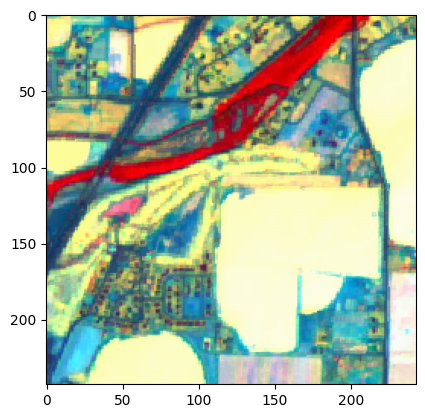

In [13]:
import matplotlib.pyplot as plt
plt.imshow(pixel_values.transpose(1,2,0))

In [14]:
import evaluate
metric = evaluate.load("mean_iou")

In [15]:
epoch_count = 30 #let's just make sure things are working, then we can go to 50 or 100

### training loop:

In [ ]:
from tqdm.auto import tqdm
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
import pandas as pd 
df_metrics =  pd.DataFrame(columns=[])

for epoch in range(epoch_count):
  print("Epoch:", epoch)
  loaded_model.train()
  #i = 0
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # i+=1
      # if i>5:
      #     break
      # Reset the parameter gradients
      optimizer.zero_grad()
      try:

      # Forward pass
          outputs = loaded_model(
              pixel_values=batch["pixel_values"].to(device),
              mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
              class_labels=[labels.to(device) for labels in batch["class_labels"]],
          )
      except Exception as e:
          print(e)
          continue
    

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 250 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

  loaded_model.eval()
  for idx, batch in enumerate(tqdm(test_dataloader)):
    
    #   break
    try:
        if idx % 1000 == 0:
            pixel_values = batch["pixel_values"][0]
            
            # Forward pass
            with torch.no_grad():
                outputs = loaded_model(pixel_values=pixel_values.unsqueeze(0).to(device))
              
            # get original images
            original_images = batch["original_images"]
            target_sizes = [(original_images[0].shape[1],original_images[0].shape[2])]
        # predict segmentation maps
        
            predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                      target_sizes=target_sizes)[0]
            # get ground truth segmentation maps
            ground_truth_segmentation_maps = batch["original_segmentation_maps"][0]
    
            metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)
            ground_truth_segmentation_maps = ground_truth_segmentation_maps.cpu()
            predicted_segmentation_maps = predicted_segmentation_maps.cpu()
            #print("Mean IoU:", metric.compute(num_labels = len(id2label), ignore_index = 0)['mean_iou'])
            metrics = metric._compute(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps,
                            num_labels= len(id2label),
                            ignore_index=0, # missing data,
                            reduce_labels=False, #processor.do_reduce_labels 
                        #nan_to_num=0,
                    )
            
                    # add per category metrics as individual key-value pairs
            per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
            per_category_iou = metrics.pop("per_category_iou").tolist()
            
            #metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
            metrics_update = {f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)}
            metrics_update['epoch'] = epoch
            metrics_update['loss'] = running_loss/num_samples
            df_metrics  = pd.concat([df_metrics, pd.DataFrame([metrics_update])], ignore_index=True)
        
            print(metrics_update)
          
    except Exception as e:
        print(e)
        continue


Epoch: 0


  0%|          | 0/4125 [00:00<?, ?it/s]

/tmp/ipykernel_4790/2850638860.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoding["pixel_values"] = [torch.tensor(el).float().to(device) for el in images]
/tmp/ipykernel_4790/2850638860.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoding['labels'] = [torch.tensor(el).long().squeeze().to(device) for el in labels]


Loss: 55.13684844970703
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
Loss: 39.59463828457289
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
Loss: 37.35518046418826
'NoneType' object is not subscriptable
Loss: 35.74782219639531
'NoneType' object is not subscriptable
'NoneTy

In [ ]:
df_metrics

In [ ]:
df_metrics[['iou_water','iou_developed','iou_corn','iou_soybeans','iou_other agriculture']].plot()

### we can save the model locally and also push it to hugging face:

In [ ]:
import os
code_path = os.getcwd()
model_dir = "mask2former_cdl_models"
os.makedirs(model_dir, exist_ok=True)
print(code_path)

model_name = 'cdl-mask2former_v0'


PATH = code_path + '/' +model_dir + '/' + model_name
print('PATH =',PATH)

torch.save(loaded_model.state_dict(), PATH)

In [ ]:
loaded_model.push_to_hub("gdurkin/cdl_mask2former_v0)